# Data Analysis of ports

## Summary statistics

In [99]:
folder_name = '90739-iuu-systems-project/'
import sys
sys.path.insert(1, sys.path[0].partition(folder_name)[0] + folder_name)
import pandas as pd
import difflib 
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
wd = "/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/"

In [101]:
reefers = pd.read_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/labels/classified_carriers_v1.csv')
path = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/xlsx/gfw_data-v2.xlsx'
port_visits = pd.read_excel(path, sheet_name='carrier_port_visit-v2')

Cleaning

In [102]:
port_visits.loc[((port_visits['port.name'] == 'ST PETERSBURG')&(port_visits['port.country'] == 'RUS')), 'port.name'] = 'SANKT-PETERBURG'
port_visits.loc[((port_visits['port.name'] == 'ANTWERP')&(port_visits['port.country'] == 'NLD')), 'port.country'] = 'BEL'
port_visits.loc[((port_visits['port.name'] == 'PANAMA CITY')&(port_visits['port.country'] == 'PAN')), 'port.name'] = 'BALBOA'
port_visits.loc[((port_visits['port.name'] == 'COLON')&(port_visits['port.country'] == 'PAN')), 'port.name'] = 'PUERTO COLON'
port_visits.loc[((port_visits['port.name'] == 'LOME')&(port_visits['port.country'] == 'GHA')), 'port.country'] = 'TGO'
port_visits.loc[((port_visits['port.name'] == 'MATADI')&(port_visits['port.country'] == 'AGO')), 'port.country'] = 'COD'

In [103]:
path = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/World_Port_Index/WPI.csv'
wpi = pd.read_csv(path)

In [104]:
## pre-processing reefers

reefers['share_of_loitering'] = reefers['loitering']/(reefers['encounter']+reefers['loitering'])
reefers['more_than_100_encounters'] = reefers['loitering'] + reefers['encounter'] > 100

In [105]:
top_120 = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')


/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_31436/4105049037.py:1: DtypeWarning: Columns (11,12,13,14,15,42,43,44,47) have mixed types. Specify dtype option on import or set low_memory=False.
  top_120 = pd.read_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')


In [106]:
# port_visits = port_visits.loc[port_visits['vessel.id'].isin(top_120['vessel.id'])] ## change this back
port_vessel_count = port_visits.groupby(['port.name', 'vessel.id'])['id'].count().reset_index()
port_vessel_with_label = port_vessel_count.merge(reefers, how='left', left_on='vessel.id', right_on='id', suffixes=('_port', '_carrier'))
share_of_loitering = port_vessel_with_label.groupby('port.name')['share_of_loitering'].mean().reset_index()
number_of_bad_visits = port_vessel_with_label.groupby('port.name')['label'].sum().reset_index()
share_of_bad_visits = port_vessel_with_label.groupby('port.name')['label'].mean().reset_index()
# ports_summary = port_visits_known_ships.merge(share_of_loitering, on='port.name', how='left')
ports_summary = share_of_loitering.merge(number_of_bad_visits, on='port.name', how='left')
ports_summary = ports_summary.merge(share_of_bad_visits, on='port.name', how='left', suffixes=('_absolute_count', '_avg'))

In [107]:
ports_summary.sort_values('label_absolute_count', ascending=False).head(20)

,port.name,share_of_loitering,label_absolute_count,label_avg
514,BUSAN,0.849673,692.0,0.837772
2127,SINGAPORE,0.915148,550.0,0.963222
371,BALBOA,0.962874,468.0,0.985263
1852,PUERTO COLON,0.964614,450.0,0.984683
1275,LAS PALMAS,0.968288,427.0,0.981609
2574,ZHOUSHAN,0.862232,412.0,0.874735
1845,PUERTO BOLIVAR,0.982370,311.0,1.000000
222,ABIDJAN,0.967003,309.0,0.984076
759,EUROPA POINT,0.981289,305.0,1.000000
2307,TEMA,0.962598,300.0,0.980392


In [108]:
data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]

countries = pd.DataFrame(data, columns=['alpha_3', 'alpha_2', 'name'])

# FIXES
wpi.loc[wpi['PORT_NAME,C,254'] == "WALVIS BAY",'COUNTRY,C,254'] = "NA"
wpi.loc[wpi['PORT_NAME,C,254'] == "HONG KONG",'COUNTRY,C,254'] = "CN"

# MERGE
wpi_w_country = wpi.merge(countries, how='left', left_on='COUNTRY,C,254', right_on='alpha_2')


In [109]:
gfw_port = port_visits[['port.lat', 'port.lon', 'port.country', 'port.name']]
gfw_port = gfw_port.groupby(['port.name', 'port.country']).mean().reset_index()
ports_summary = ports_summary.merge(gfw_port, on='port.name', how='left')

In [110]:
manual_matched = {
    'SINGAPORE': 'KEPPEL - (EAST SINGAPORE)',
    'SAINT PETERSBURG': 'SANKT-PETERBURG',
    'ADMIRALTEISKY': 'SANKT-PETERBURG',
    'SKAGEN': 'SKAGEN HAVN',
    'NIEUW- EN SINT JOOSLAND': 'VLISSINGEN',
    'MAJURO': 'MAJURO ATOLL',
    'POHNPEI': 'POHNPEI HARBOR',
    'VELSEN-NOORD': 'IJMUIDEN',
    'QINGDAO': 'QINGDAO GANG',
    'TARAWA': 'TARAWA ATOLL',
    'GUAYAQUIL GULF': 'PUERTO MARITIMO DE GUAYAQUIL',
    'CALLAO': 'PUERTO DEL CALLAO',
    'BERKELEY SOUND': 'STANLEY',
    'GOTHENBURG': 'GOTEBORG',
    'TOKYO': 'TOKYO KO',
    'MOIN': 'PUERTO MOIN',
    'SALTANGARA': 'RUNAVIK',
    'GUADARRANQUE': 'ALGECIRAS',
    'SUEZ': 'AS SUWAYS',
    'BORSSELE': 'VLISSINGEN',
    'PHRA PRADAENG': 'BANGKOK',
    'RECALADA': 'MONTEVIDEO',
    'PORT SAID': 'BUR SAID (PORT SAID)',
    'SEKONDI-TAKORADI': 'TAKORADI',
    'POSORJA': 'PUERTO MARITIMO DE GUAYAQUIL'
    # 'ST PETERSBURG': 'SANKT-PETERBURG'
}

In [111]:
## fuzzy matching
ports_summary['port_matched'] = ports_summary['port.name'].apply(lambda x: ''.join(difflib.get_close_matches(str(x), wpi_w_country['PORT_NAME,C,254'], n=1, cutoff=0.8)))

for key in manual_matched.keys():
    ports_summary.loc[ports_summary['port.name'] == key, 'port_matched'] = manual_matched[key]
ports_matched = ports_summary.merge(wpi_w_country, how='left', left_on=['port_matched','port.country'], right_on=['PORT_NAME,C,254','alpha_3'],)


In [112]:
ports_matched.loc[ports_matched['HARBORSIZE,C,254'].isna(),:].sort_values(by='label_absolute_count',ascending=False).head(15)

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
2144,SINGAPORE,0.915148,550.0,0.963222,MYS,1.660950,104.594164,KEPPEL - (EAST SINGAPORE),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,ARNEMUIDEN,0.994960,120.0,1.000000,NLD,51.452462,3.587500,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,LONDON,0.915784,107.0,0.981651,KIR,1.982373,-157.499609,LONDON,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832,PORTSMOUTH,0.999185,99.0,1.000000,GBR,50.705088,-1.084368,PORTSMOUTH,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2470,VICTORIA,0.930223,98.0,0.989899,CAN,48.343793,-123.353623,VICTORIA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1369,MALTA,0.958736,95.0,0.989583,MLT,35.915676,14.676923,ALTA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
825,FUNAFUTI,0.900679,95.0,0.979381,TUV,-8.501402,178.379840,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1086,JINHAE MAN,0.811393,92.0,0.754098,KOR,35.018909,128.660835,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,BANG KHO LAEM,0.911137,88.0,0.988764,THA,13.632248,100.528297,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,SAN ANTONIO ESTE,0.990097,83.0,1.000000,ARG,-40.844472,-64.781923,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
ports_matched.sort_values(by='label_absolute_count',ascending=False).head(15)[['port.name', 'port.country', 'port_matched', 'COUNTRY,C,254', 'PORT_NAME,C,254']]

,port.name,port.country,port_matched,"COUNTRY,C,254","PORT_NAME,C,254"
515,BUSAN,KOR,ULSAN,KR,ULSAN
2145,SINGAPORE,SGP,KEPPEL - (EAST SINGAPORE),SG,KEPPEL - (EAST SINGAPORE)
2144,SINGAPORE,MYS,KEPPEL - (EAST SINGAPORE),NaN,NaN
371,BALBOA,PAN,BALBOA,PA,BALBOA
1867,PUERTO COLON,PAN,PUERTO COLON,PA,PUERTO COLON
1283,LAS PALMAS,ESP,LAS PALMAS,ES,LAS PALMAS
2598,ZHOUSHAN,CHN,ZHOUSHAN,CN,ZHOUSHAN
1858,PUERTO BOLIVAR,COL,PUERTO BOLIVAR,CO,PUERTO BOLIVAR
1859,PUERTO BOLIVAR,ECU,PUERTO BOLIVAR,EC,PUERTO BOLIVAR
222,ABIDJAN,CIV,ABIDJAN,CI,ABIDJAN


In [114]:
all_data = ports_matched \
    .merge(port_visits, on='port.name', how='left')

all_data['year'] = all_data['start'].str[:4]

all_data = all_data.groupby(['port.name', 'year'])['label_absolute_count'].sum().reset_index()

In [115]:
all_data = ports_matched \
    .merge(port_visits, on='port.name', how='left')

all_data['year'] = all_data['start'].str[:4]

all_data = all_data.loc[all_data['vessel.id'].isin(reefers['id']),:]

all_data = all_data.groupby(['port.name', 'year']).count().reset_index()

all_data = all_data[['port.name','year','share_of_loitering']].rename({'share_of_loitering':'number_of_visits'},axis = 1)

csv by port size

In [116]:
large_ports = ports_matched.loc[ports_matched['HARBORSIZE,C,254'] == 'L',:] \
    .sort_values(by='label_absolute_count',ascending=False) \
    .head(15)
large_ports.to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/large_ports.csv')
large_ports

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
2145,SINGAPORE,0.915148,550.0,0.963222,SGP,1.346778,103.810522,KEPPEL - (EAST SINGAPORE),50000.0,49990.0,...,Y,Y,Y,Y,A,L,S,SGP,SG,Singapore
1283,LAS PALMAS,0.968288,427.0,0.981609,ESP,28.121059,-15.391801,LAS PALMAS,38170.0,38140.0,...,Y,NaN,NaN,NaN,B,NaN,L,ESP,ES,Spain
222,ABIDJAN,0.967003,309.0,0.984076,CIV,5.239332,-4.018913,ABIDJAN,46000.0,45960.0,...,Y,Y,Y,Y,B,S,NaN,CIV,CI,Côte d'Ivoire
2004,SAINT PETERSBURG,0.972342,297.0,0.973770,RUS,59.884437,30.159237,SANKT-PETERBURG,28370.0,28250.0,...,Y,NaN,Y,Y,A,NaN,M,RUS,RU,Russian Federation
2047,SANKT-PETERBURG,0.974185,296.0,0.976898,RUS,60.016455,29.400889,SANKT-PETERBURG,28370.0,28250.0,...,Y,NaN,Y,Y,A,NaN,M,RUS,RU,Russian Federation
545,CAPE TOWN,0.950359,290.0,0.983051,ZAF,-33.895129,18.410600,CAPE TOWN,46770.0,46725.0,...,Y,Y,Y,Y,A,L,L,ZAF,ZA,South Africa
719,DURBAN,0.976496,262.0,0.996198,ZAF,-29.836080,31.077707,DURBAN,46850.0,46725.0,...,Y,Y,Y,Y,B,L,L,ZAF,ZA,South Africa
643,DALIAN,0.791376,260.0,0.751445,CHN,38.952360,121.868186,DALIAN,60250.0,59850.0,...,Y,NaN,Y,Y,A,M,M,CHN,CN,China
1269,LAGOS,0.951502,232.0,0.970711,NGA,6.312839,3.364678,LAGOS,46130.0,46120.0,...,Y,Y,Y,Y,C,M,M,NGA,NG,Nigeria
233,ADMIRALTEISKY,0.982833,224.0,0.986784,RUS,59.903832,30.167636,SANKT-PETERBURG,28370.0,28250.0,...,Y,NaN,Y,Y,A,NaN,M,RUS,RU,Russian Federation


In [117]:
medium_ports = ports_matched.loc[ports_matched['HARBORSIZE,C,254'] == 'M',:] \
    .sort_values(by='label_absolute_count',ascending=False) \
    .head(15)
medium_ports.to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/medium_ports.csv')
medium_ports

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
515,BUSAN,0.849673,692.0,0.837772,KOR,35.038632,129.039422,ULSAN,60400.0,60315.0,...,Y,Y,NaN,NaN,C,M,M,KOR,KR,"Korea, Republic of"
371,BALBOA,0.962874,468.0,0.985263,PAN,8.957531,-79.585912,BALBOA,15410.0,15380.0,...,Y,Y,Y,Y,A,L,M,PAN,PA,Panama
1867,PUERTO COLON,0.964614,450.0,0.984683,PAN,9.322886,-79.905398,PUERTO COLON,9865.0,9820.0,...,Y,NaN,NaN,NaN,N,NaN,S,PAN,PA,Panama
761,EUROPA POINT,0.981289,305.0,1.000000,GIB,36.106506,-5.355984,EUROPA POINT,38330.0,38320.0,...,Y,Y,Y,Y,A,M,S,GIB,GI,Gibraltar
2524,WEIHAI,0.866633,294.0,0.918750,CHN,36.913766,122.385569,WEIHAI,60150.0,59850.0,...,Y,NaN,Y,NaN,NaN,NaN,NaN,CHN,CN,China
640,DAKAR,0.984766,273.0,1.000000,SEN,14.656881,-17.403562,DAKAR,45820.0,45817.0,...,Y,Y,Y,Y,B,M,L,SEN,SN,Senegal
1593,NOUADHIBOU,0.956105,255.0,0.969582,MRT,20.828737,-17.038624,NOUADHIBOU,45812.0,45810.0,...,Y,Y,N,N,C,NaN,L,MRT,MR,Mauritania
694,DOUALA,0.967338,218.0,0.986425,CMR,3.953944,9.583459,DOUALA,46280.0,46250.0,...,Y,Y,Y,Y,A,L,L,CMR,CM,Cameroon
1569,NIEUW- EN SINT JOOSLAND,0.986269,217.0,0.990868,NLD,51.459886,3.589777,VLISSINGEN,31210.0,30980.0,...,Y,Y,Y,Y,A,M,S,NLD,NL,Netherlands
1120,KAOHSIUNG,0.877893,214.0,0.942731,TWN,22.556778,120.288278,KAO-HSIUNG,57920.0,57880.0,...,Y,Y,NaN,NaN,B,L,S,TWN,TW,"Taiwan, Province of China"


In [118]:
small_ports = ports_matched.loc[ports_matched['HARBORSIZE,C,254'] == 'S',:] \
    .sort_values(by='label_absolute_count',ascending=False) \
    .head(15)
small_ports.to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/small_ports.csv')
small_ports

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
2598,ZHOUSHAN,0.862232,412.0,0.874735,CHN,30.026762,122.324997,ZHOUSHAN,59960.0,59850.0,...,NaN,Y,NaN,NaN,C,M,NaN,CHN,CN,China
1858,PUERTO BOLIVAR,0.982370,311.0,1.000000,COL,12.265718,-72.016549,PUERTO BOLIVAR,11946.0,11860.0,...,N,N,NaN,NaN,N,NaN,M,COL,CO,Colombia
2326,TEMA,0.962598,300.0,0.980392,GHA,5.577731,0.027976,TEMA,46070.0,46010.0,...,Y,Y,Y,Y,B,M,M,GHA,GH,Ghana
2154,SKAGEN,0.965619,249.0,0.961390,DNK,57.677263,10.669752,SKAGEN HAVN,30440.0,30020.0,...,Y,NaN,NaN,Y,C,NaN,S,DNK,DK,Denmark
900,GUAYAQUIL,0.987604,247.0,1.000000,ECU,-2.333084,-79.975940,GUAYAQUIL,15270.0,15240.0,...,Y,NaN,Y,Y,C,S,M,ECU,EC,Ecuador
1784,PORT LOUIS,0.902681,216.0,0.981818,MUS,-20.133792,57.475073,PORT LOUIS,47720.0,47710.0,...,Y,Y,Y,Y,B,M,NaN,MUS,MU,Mauritius
1023,IJMUIDEN,0.964178,200.0,0.970874,NLD,52.466775,4.542396,IJMUIDEN,31040.0,30980.0,...,Y,NaN,NaN,Y,C,NaN,S,NLD,NL,Netherlands
1736,POHNPEI,0.905191,187.0,0.968912,FSM,6.989443,158.171949,POHNPEI HARBOR,56590.0,56560.0,...,Y,NaN,NaN,NaN,D,NaN,NaN,FSM,FM,"Micronesia, Federated States of"
2459,VELSEN-NOORD,0.937898,185.0,0.939086,NLD,52.468577,4.597106,IJMUIDEN,31040.0,30980.0,...,Y,NaN,NaN,Y,C,NaN,S,NLD,NL,Netherlands
267,ALGECIRAS,0.986492,180.0,0.994475,ESP,36.088325,-5.398069,ALGECIRAS,38310.0,38200.0,...,Y,Y,NaN,NaN,B,L,S,ESP,ES,Spain


In [119]:
very_small_ports = ports_matched.loc[ports_matched['HARBORSIZE,C,254'] == 'V',:] \
    .sort_values(by='label_absolute_count',ascending=False) \
    .head(15)
very_small_ports.to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/very_small_ports.csv')
very_small_ports

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
1859,PUERTO BOLIVAR,0.982370,311.0,1.000000,ECU,-3.235473,-80.021807,PUERTO BOLIVAR,15250.0,15240.0,...,NaN,N,NaN,NaN,N,NaN,S,ECU,EC,Ecuador
1359,MAJURO,0.905299,208.0,0.954128,MHL,7.104302,171.334050,MAJURO ATOLL,56400.0,56340.0,...,Y,Y,NaN,NaN,C,NaN,S,MHL,MH,Marshall Islands
1775,PORT HARCOURT,0.959210,206.0,0.990385,NGA,4.645908,7.039621,PORT HARCOURT,46210.0,46120.0,...,Y,Y,N,N,B,NaN,M,NGA,NG,Nigeria
1888,PUERTO MOIN,0.995751,184.0,1.000000,CRI,10.061495,-82.997340,PUERTO MOIN,9805.0,9800.0,...,Y,NaN,NaN,NaN,C,NaN,S,CRI,CR,Costa Rica
2312,TARAWA,0.910329,171.0,0.977143,KIR,1.381233,172.931309,TARAWA ATOLL,56450.0,56430.0,...,Y,N,Y,Y,C,NaN,NaN,KIR,KI,Kiribati
2400,TURBO,0.990431,169.0,1.000000,COL,8.039446,-76.813203,TURBO,11880.0,11860.0,...,N,N,N,N,NaN,NaN,NaN,COL,CO,Colombia
2084,SCHIEDAM,0.995274,168.0,1.000000,NLD,51.946232,4.205769,SCHIEDAM,31130.0,30980.0,...,Y,Y,NaN,Y,A,M,S,NLD,NL,Netherlands
828,FUZHOU,0.871515,162.0,0.931034,CHN,26.032559,119.724502,FUZHOU,59860.0,59850.0,...,Y,NaN,Y,NaN,C,NaN,NaN,CHN,CN,China
641,DAKHLA,0.948743,130.0,0.977444,ESH,23.633261,-16.021020,AD DAKHLA,45808.0,45805.0,...,Y,Y,NaN,NaN,C,NaN,NaN,ESH,EH,Western Sahara
1458,MOIN,0.999051,124.0,1.000000,CRI,10.106666,-82.984435,PUERTO MOIN,9805.0,9800.0,...,Y,NaN,NaN,NaN,C,NaN,S,CRI,CR,Costa Rica


In [120]:
unknown_ports = ports_matched.loc[ports_matched['HARBORSIZE,C,254'].isna(),:] \
    .sort_values(by='label_absolute_count',ascending=False) \
    .head(15)
unknown_ports.to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/unknown_port_size.csv')
unknown_ports

,port.name,share_of_loitering,label_absolute_count,label_avg,port.country,port.lat,port.lon,port_matched,"INDEX_NO,N,16,6","REGION_NO,N,16,6",...,"FUEL_OIL,C,254","DIESEL,C,254","DECKSUPPLY,C,254","ENG_SUPPLY,C,254","REPAIRCODE,C,254","DRYDOCK,C,254","RAILWAY,C,254",alpha_3,alpha_2,name
2144,SINGAPORE,0.915148,550.0,0.963222,MYS,1.660950,104.594164,KEPPEL - (EAST SINGAPORE),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,ARNEMUIDEN,0.994960,120.0,1.000000,NLD,51.452462,3.587500,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,LONDON,0.915784,107.0,0.981651,KIR,1.982373,-157.499609,LONDON,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832,PORTSMOUTH,0.999185,99.0,1.000000,GBR,50.705088,-1.084368,PORTSMOUTH,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2470,VICTORIA,0.930223,98.0,0.989899,CAN,48.343793,-123.353623,VICTORIA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1369,MALTA,0.958736,95.0,0.989583,MLT,35.915676,14.676923,ALTA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
825,FUNAFUTI,0.900679,95.0,0.979381,TUV,-8.501402,178.379840,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1086,JINHAE MAN,0.811393,92.0,0.754098,KOR,35.018909,128.660835,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,BANG KHO LAEM,0.911137,88.0,0.988764,THA,13.632248,100.528297,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,SAN ANTONIO ESTE,0.990097,83.0,1.000000,ARG,-40.844472,-64.781923,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


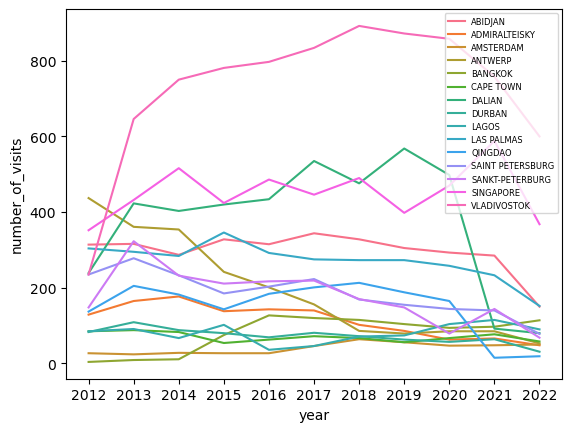

In [121]:
sns.lineplot(all_data.loc[all_data['port.name'].isin(large_ports['port.name']),:], x='year', y='number_of_visits', hue='port.name') \
    .legend(fontsize=6)
plt.show()

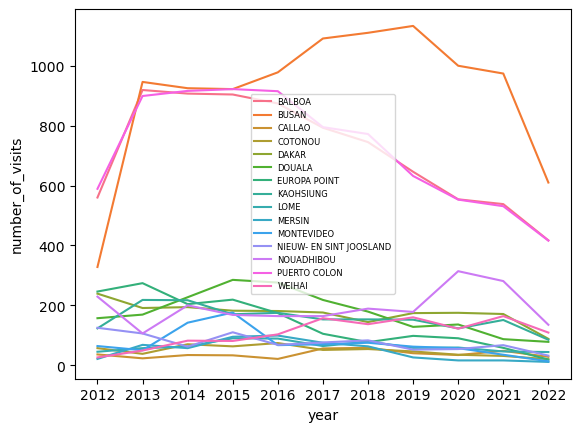

In [122]:
sns.lineplot(all_data.loc[all_data['port.name'].isin(medium_ports['port.name']),:], x='year', y='number_of_visits', hue='port.name') \
    .legend(fontsize=6)
plt.show()

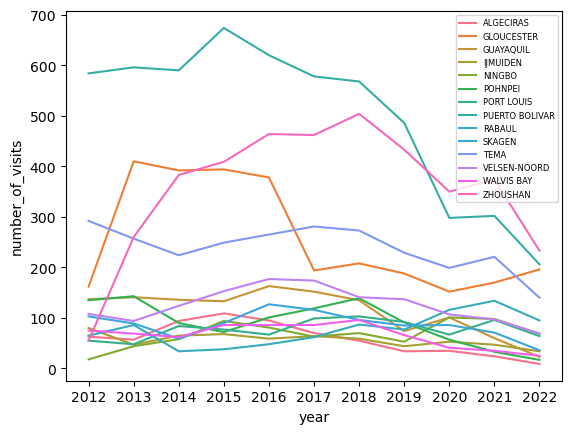

In [123]:
sns.lineplot(all_data.loc[all_data['port.name'].isin(small_ports['port.name']),:], x='year', y='number_of_visits', hue='port.name') \
    .legend(fontsize=6)
plt.show()

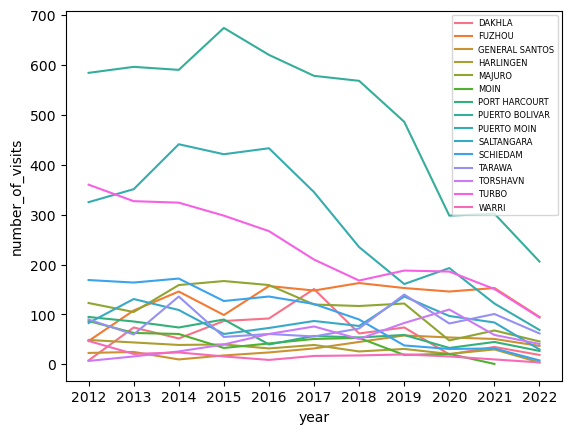

In [124]:
sns.lineplot(all_data.loc[all_data['port.name'].isin(very_small_ports['port.name']),:], x='year', y='number_of_visits', hue='port.name') \
    .legend(fontsize=6)
plt.show()

In [125]:
all_data.loc[all_data['port.name'].isin(large_ports['port.name']),:].to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/proc/ports/large_ports_over_time.csv')

To-do:
- extract which loiterings happened before which ports visits